In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from collections import Counter
from prophet import Prophet

In [2]:
data = pd.read_csv('web-traffic-time-series-forecasting/train_2.csv/train_2.csv').fillna(0)
data.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        26.0  ...        19.0        33.0        33.0        18.0   
1        10.0  ...        32.0        30.0        11.0        19.0   
2         4.0  ...         6.0         6.0         7.0         2.0   
3        11.0  ...         7.0        19.0        19.0         9.0   
4         0.0  ...        16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 804 columns]

In [3]:
print(data.shape)

(145063, 804)


In [3]:
#Select only data up to 31/07/2017
date_cols = pd.to_datetime(data.columns[1:], errors="coerce")
train_mask = [True] + list(date_cols <= "2017-07-31")  # include first column
train = data.loc[:, train_mask]

train_dates = date_cols[date_cols <= "2017-07-31"]

In [4]:
test_mask = [True] + list((date_cols >= "2017-08-01") & (date_cols <= "2017-09-10"))
test = data.loc[:, test_mask]

test_dates = date_cols[(date_cols >= "2017-08-01") & (date_cols <= "2017-09-10")]

In [5]:
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2017-07-22  2017-07-23  2017-07-24  2017-07-25  \
0        26.0  ...        12.0        20.0        16.0        31.0   
1        10.0  ...        16.0        11.0        44.0        18.0   
2         4.0  ...         3.0         5.0         8.0         2.0   
3        11.0  ...         7.0        15.0        19.0         9.0   
4         0.0  ...        11.0         8.0         9.0         7.0   

   2017-07-26  2017-07-27  2017-07-28  2017-07-29  2017-07-30  2017-07-31  
0        19.0        14.0        20.0        13.0        22.0        14.0  
1        13.0        12.0         8.0        21.0        15.0        14.0  
2         3.0         3.0         2.0         5.0         7.0         4.0  
3        10.0        11.0        21.0        14.0        13.0        13.0  
4        10.0         3.0        14.0         4.0         4.0        15.0  

[5 rows x 763 columns]

In [6]:
test.head()

Page  2017-08-01  2017-08-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        20.0        46.0   
1             2PM_zh.wikipedia.org_all-access_spider        18.0        39.0   
2              3C_zh.wikipedia.org_all-access_spider         0.0        22.0   
3         4minute_zh.wikipedia.org_all-access_spider        14.0        37.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...        14.0        40.0   

   2017-08-03  2017-08-04  2017-08-05  2017-08-06  2017-08-07  2017-08-08  \
0        24.0        22.0        22.0        11.0        25.0        45.0   
1        20.0        31.0        19.0         7.0        11.0        20.0   
2         8.0         4.0         3.0         1.0         3.0         7.0   
3        14.0        12.0        13.0        11.0        10.0        14.0   
4        39.0        66.0       114.0        19.0        29.0        12.0   

   2017-08-09  ...  2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        39.0  ...        19.0        33.0        33.0        18.0   
1        13.0  ...        32.0        30.0        11.0        19.0   
2         3.0  ...         6.0         6.0         7.0         2.0   
3        15.0  ...         7.0        19.0        19.0         9.0   
4        11.0  ...        16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 42 columns]

C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\212107106.py:23: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\212107106.py:23: UserWarning: Glyph 39791 (\N{CJK UNIFIED IDEOGRAPH-9B6F}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\212107106.py:23: UserWarning: Glyph 38307 (\N{CJK UNIFIED IDEOGRAPH-95A3}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\212107106.py:23: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\212107106.py:23: UserWarning: Glyph 34905 (\N{CJK UNIFIED IDEOGRAPH-8859}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\212107106.py:23: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from cur

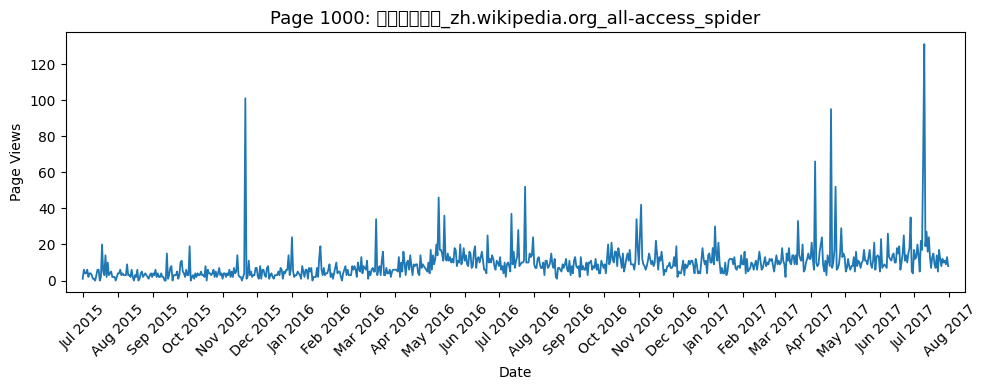

In [8]:

def plot_entry(idx):
    data = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, data.values, linewidth=1.3)
    plt.title(f"Page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')
    #plt.grid(True, alpha=0.3)


    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    plt.show()

plot_entry(1000)



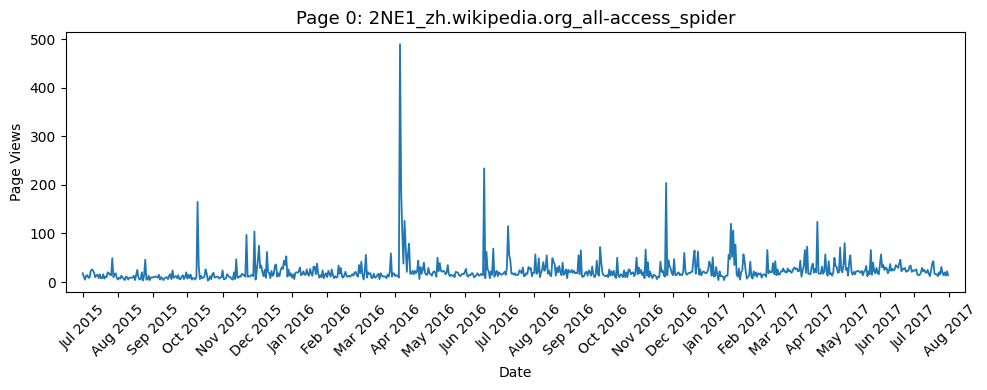

In [9]:
def plot_and_save_entry(idx):
    """
    Plot time series for a given index and save the image to plots folder
    
    Parameters:
    idx (int): Index of the row to plot
    """
    
    # Get the data and page name
    data = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, data.values, linewidth=1.3)
    plt.title(f"Page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    
    # Save the plot
    filename = f'plots/plot_{idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')


plot_and_save_entry(0)  # Plot and save the first time series

C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:29: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:29: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:29: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:33: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:33: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:33: UserWarn

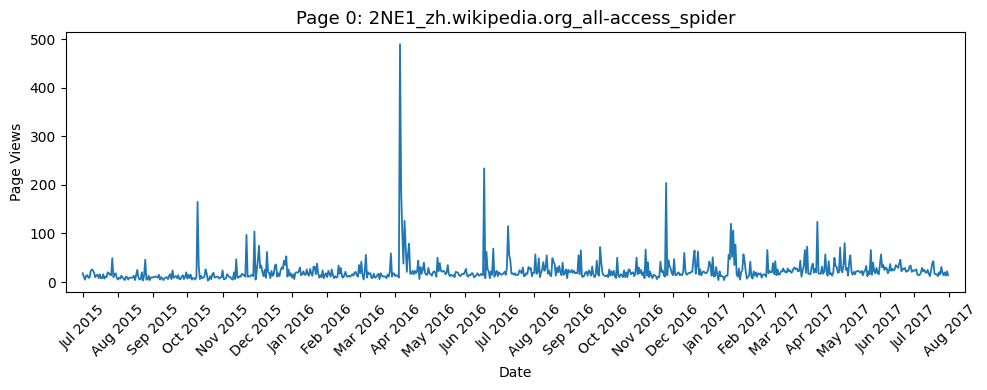

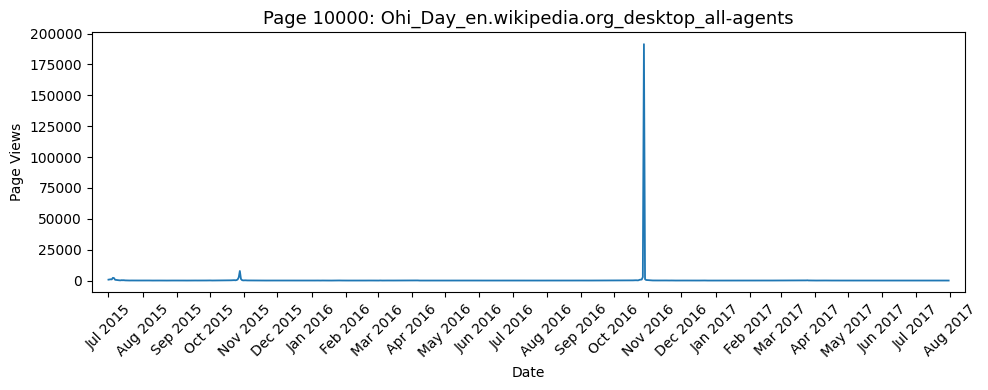

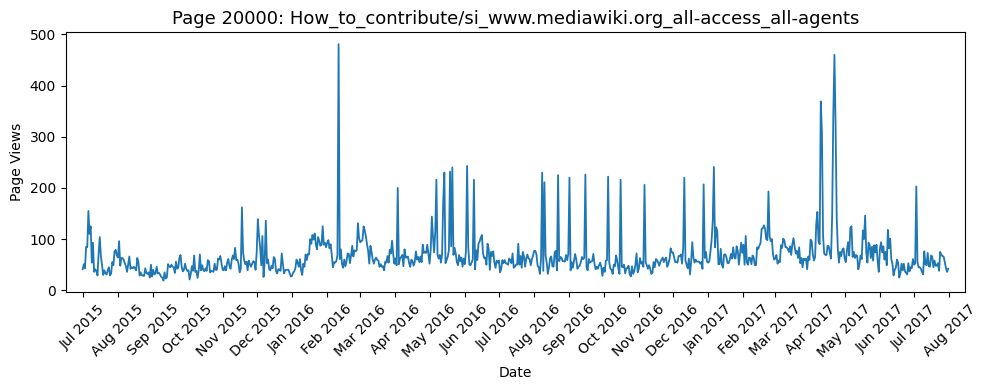

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


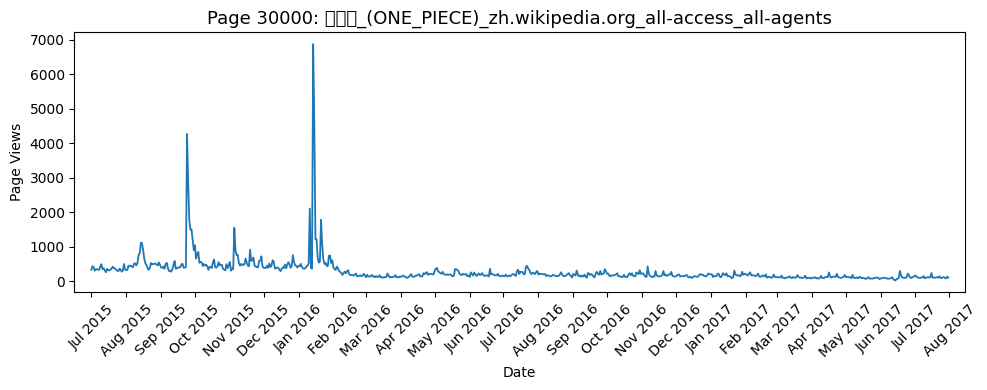

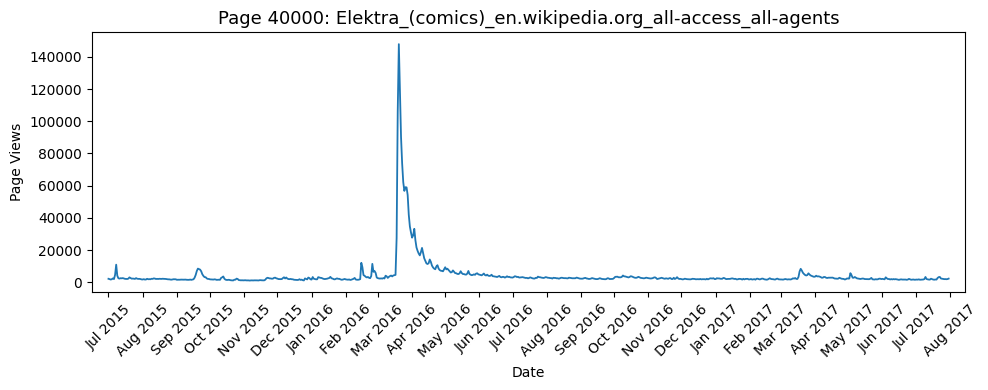

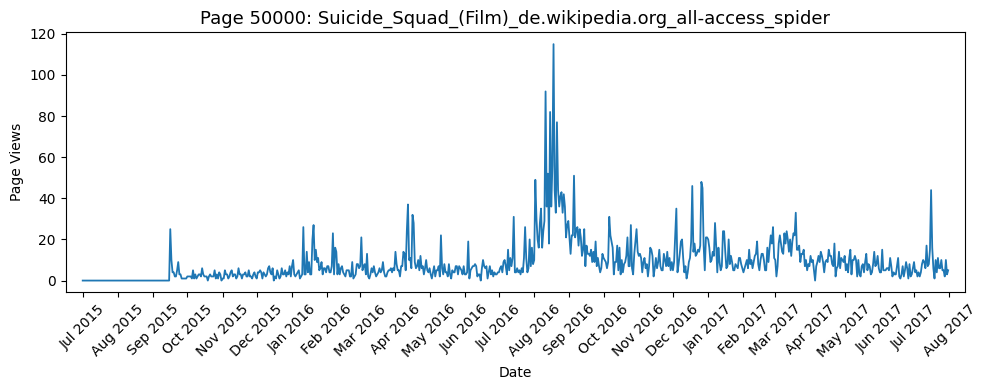

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


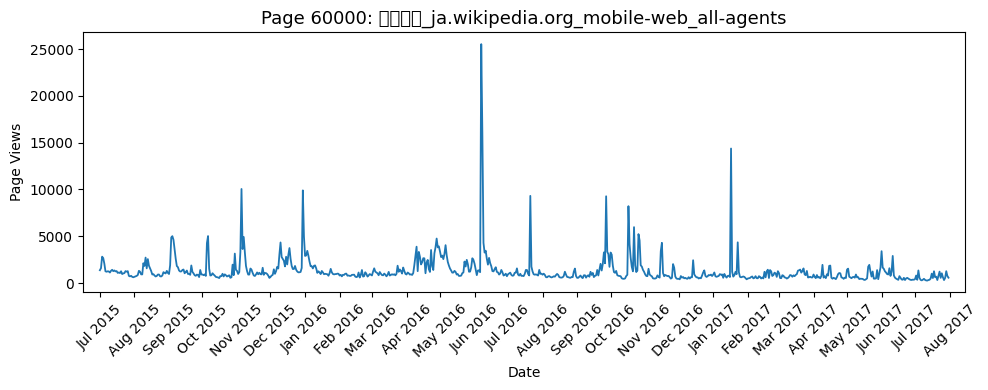

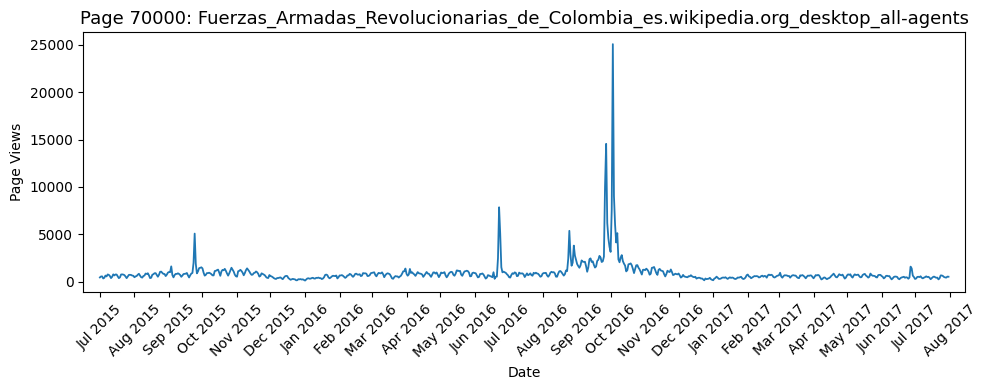

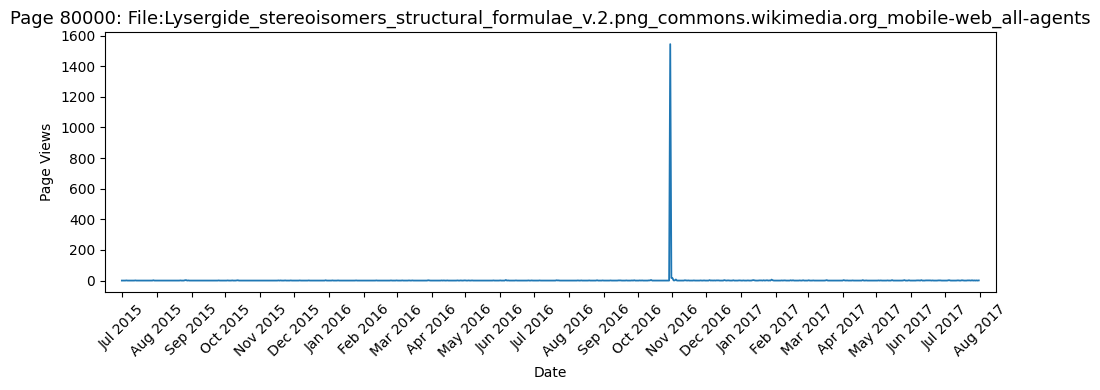

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-ana

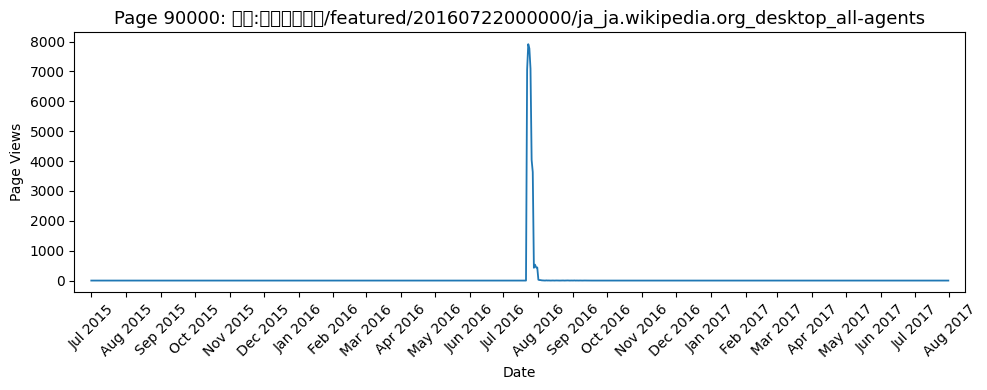

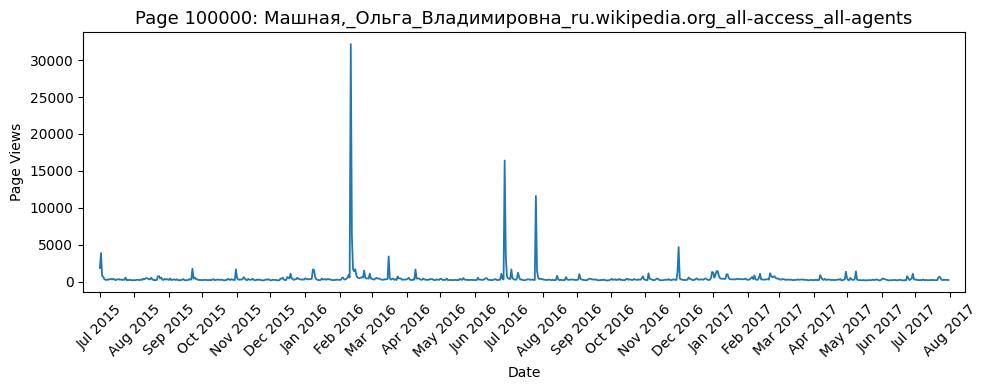

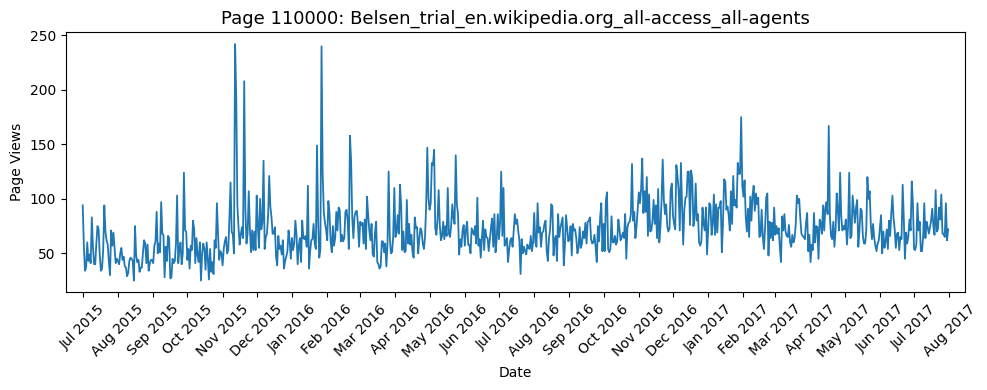

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24736 (\N{CJK UNIFIED IDEOGRAPH-60A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-a

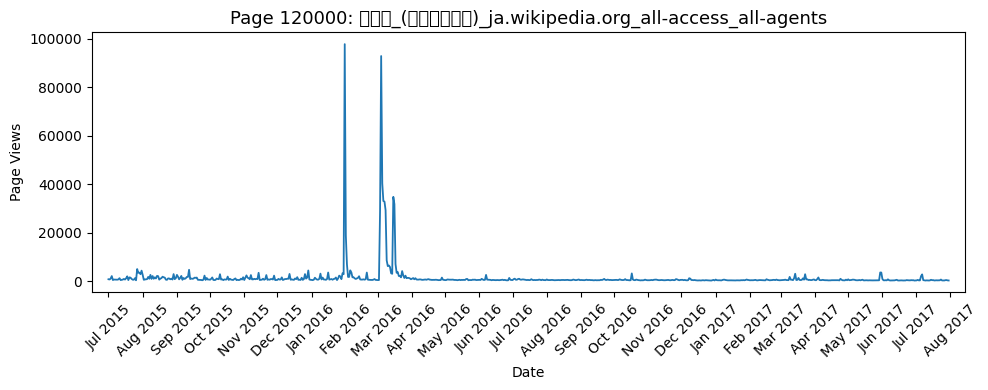

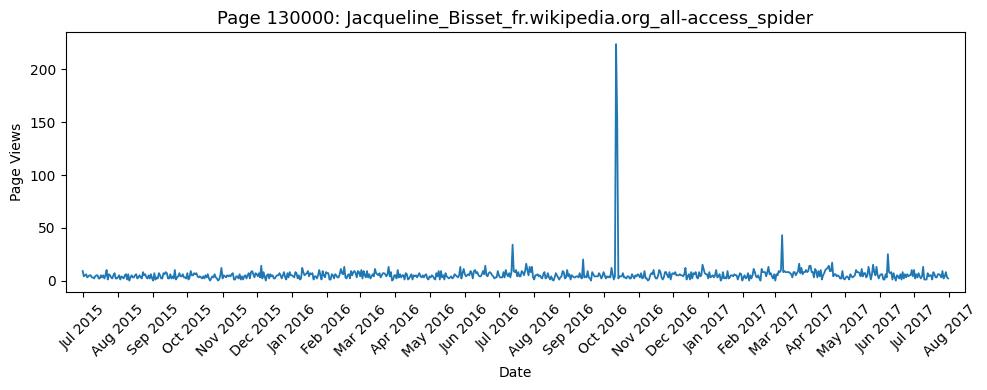

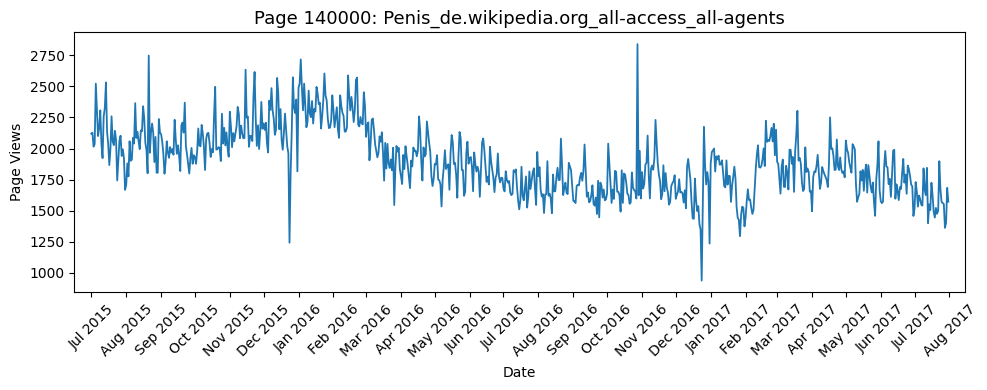

In [10]:
for i in range(0, 15):
    plot_and_save_entry(i*10000) 

In [6]:
def get_language(page):
    # Regex with a capturing group for the language code
    match = re.search(r'([a-z]{2})\.wikipedia\.org', page)
    if match:
        return match.group(1)  # get the captured language code
    return 'na'

train.loc[:, 'lang'] = train['Page'].map(get_language)

test.loc[:, 'lang'] = test['Page'].map(get_language)

print(Counter(train.lang))
print(Counter(test.lang))

C:\Users\arsen\AppData\Local\Temp\ipykernel_6652\3798372893.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'lang'] = train['Page'].map(get_language)
C:\Users\arsen\AppData\Local\Temp\ipykernel_6652\3798372893.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'lang'] = test['Page'].map(get_language)


Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})
Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [7]:
lang_sets = {
    lang: train[train.lang == lang].iloc[:, 0:-1]
    for lang in train['lang'].unique()
}

avg_views_by_lang = {
    lang: df.iloc[:, 1:].sum(axis=0) / df.shape[0]
    for lang, df in lang_sets.items()
}

In [8]:
lang_sets_test = {
    lang: test[test.lang == lang].iloc[:, 0:-1]
    for lang in test['lang'].unique()
}

avg_views_by_lang_test = {
    lang: df.iloc[:, 1:].sum(axis=0) / df.shape[0]
    for lang, df in lang_sets_test.items()
}

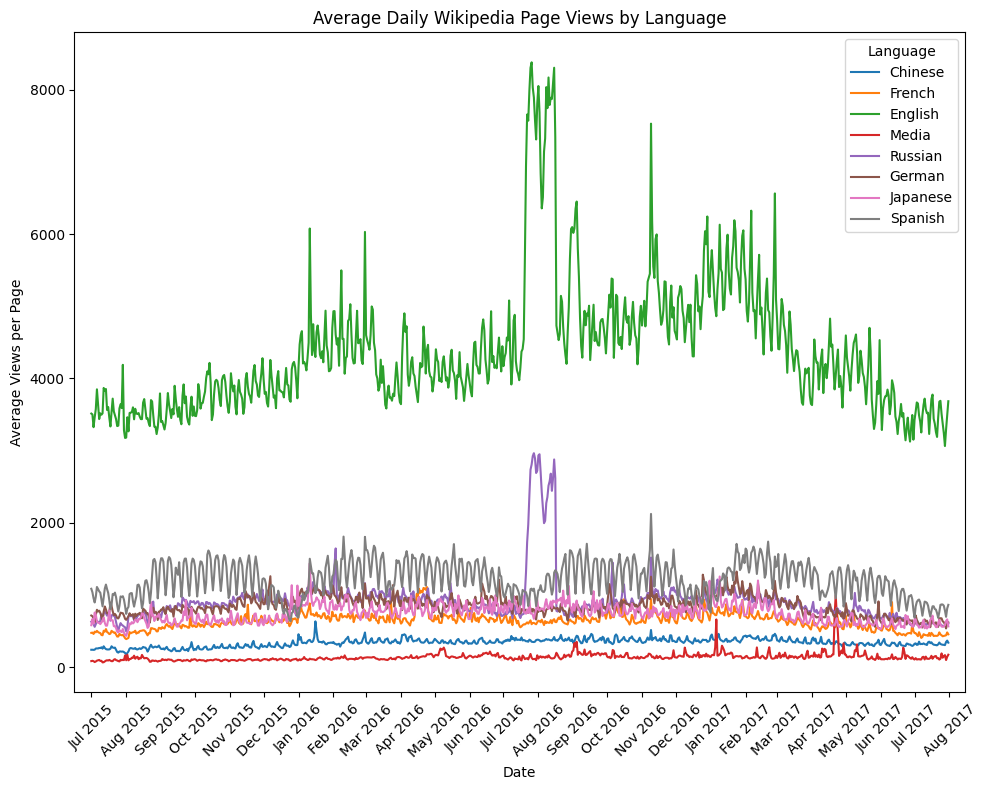

In [10]:
fig = plt.figure(figsize=[10,8])
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Average Daily Wikipedia Page Views by Language')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for lang, series in avg_views_by_lang.items():
    plt.plot(train_dates, series.values, label=labels.get(lang, lang))

plt.legend(title='Language')

ax = plt.gca()

# Ticks at start of month
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

plt.tight_layout()
plt.show()

In [14]:
for lang, series in avg_views_by_lang.items():
    avg_views_by_lang[lang].index = pd.to_datetime(series.index)

In [15]:
for lang, series in avg_views_by_lang_test.items():
    avg_views_by_lang_test[lang].index = pd.to_datetime(series.index)

In [17]:
def plot_and_save_lang(lang):
    """
    Plot average daily wikipedia page views for a given language and save the image to plots folder
    
    Parameters:
    lang (string): Language code
    """
    
    plt.figure(figsize=(10, 4))

    plt.ylabel('Average Views per Page')
    plt.xlabel('Date')
    plt.title(labels.get(lang, lang) + ' Wikipedia Subset: Average Daily Page Views')

    
    plt.plot(avg_views_by_lang[lang].index, avg_views_by_lang[lang].values)
   
    ax = plt.gca()

    # Ticks at start of month
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()

    
    # Save the plot
    filename = f'plots/plot_{lang}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()



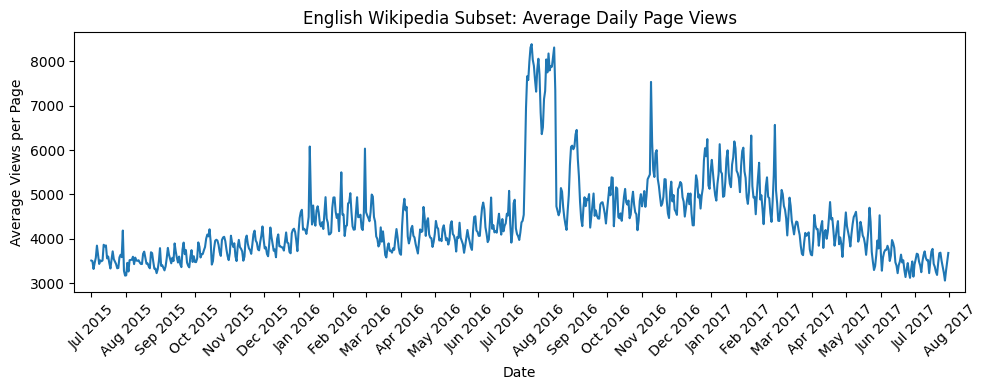

In [18]:
plot_and_save_lang('en')

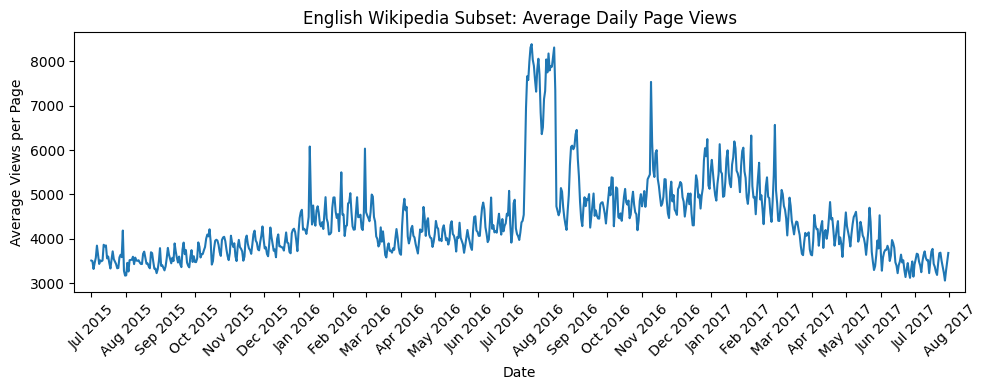

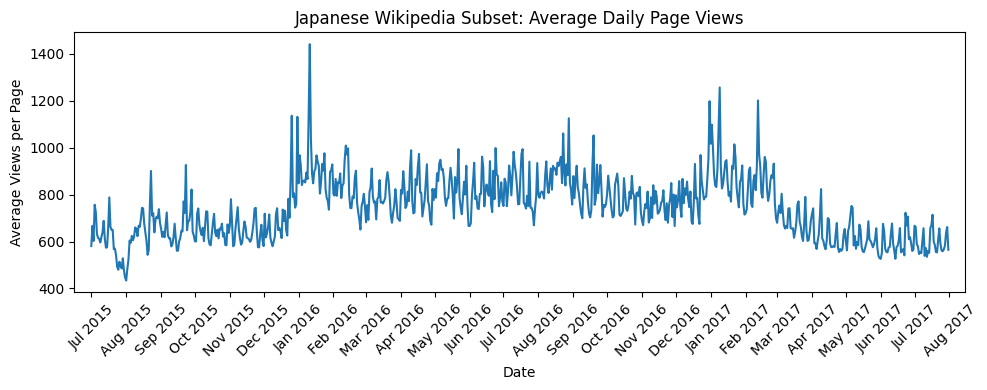

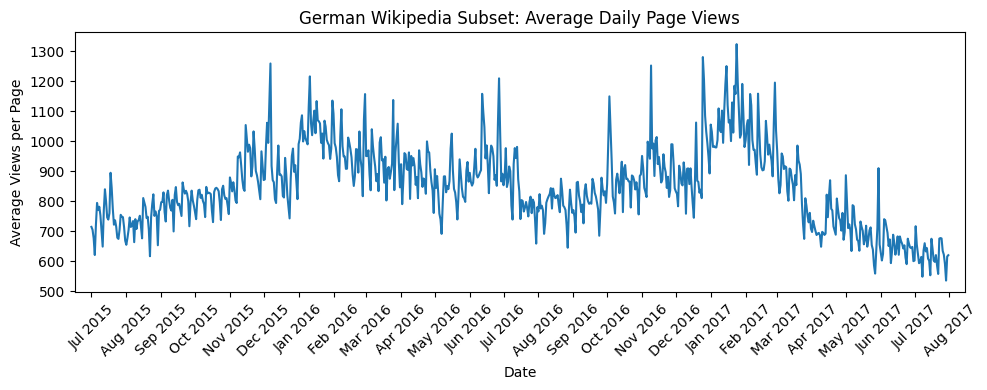

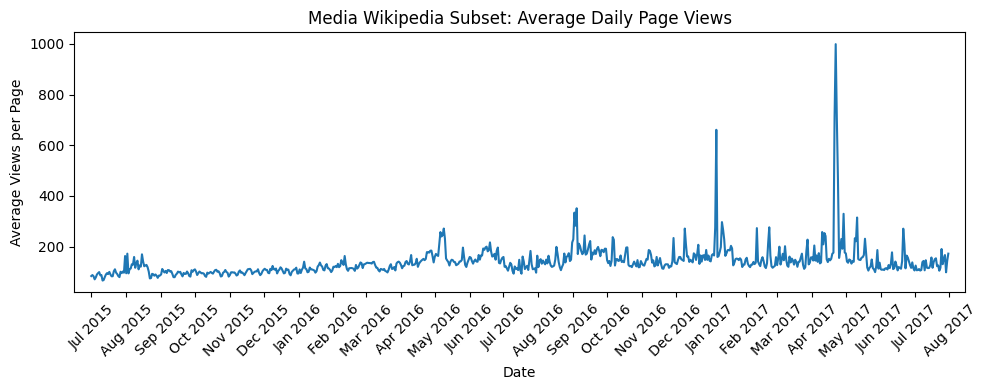

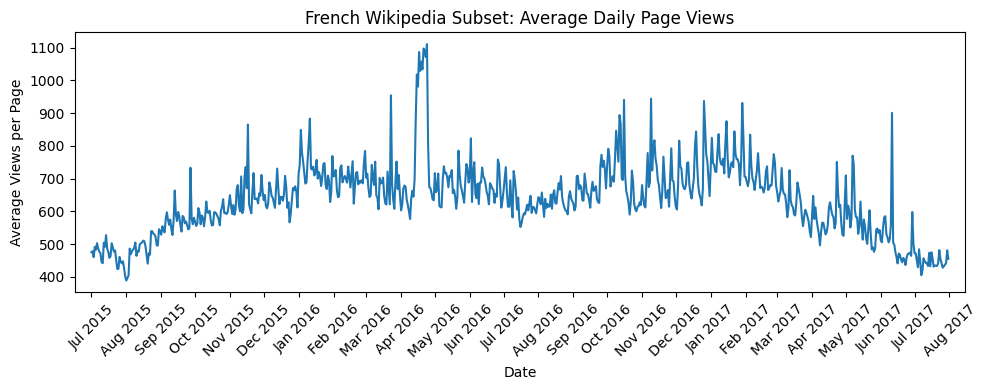

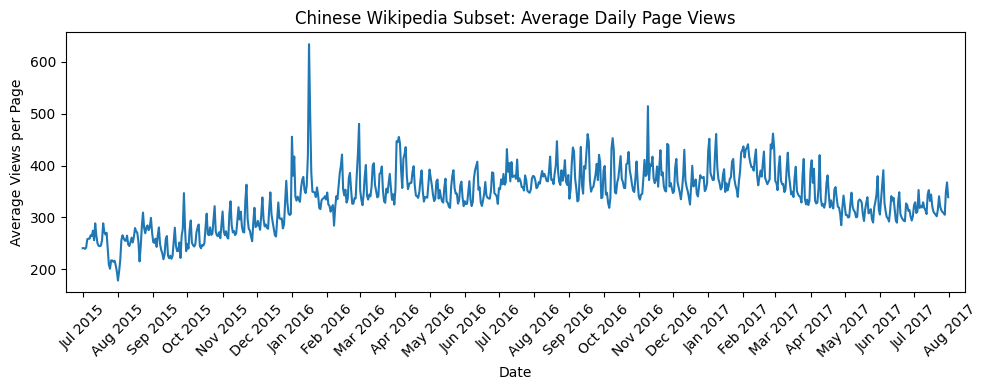

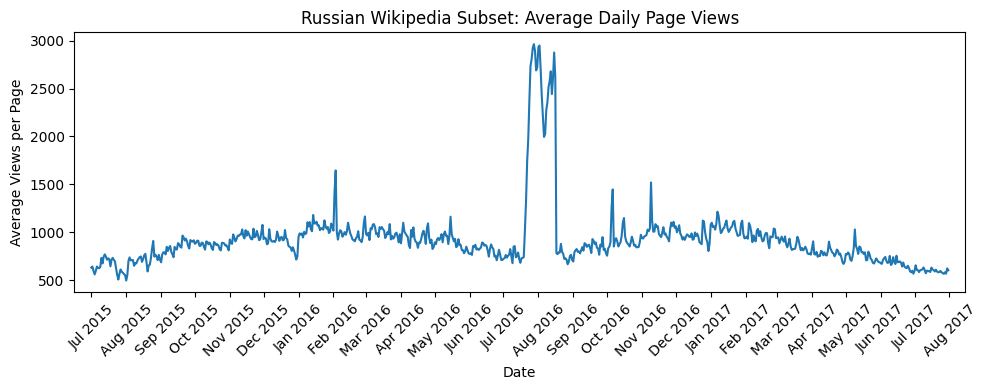

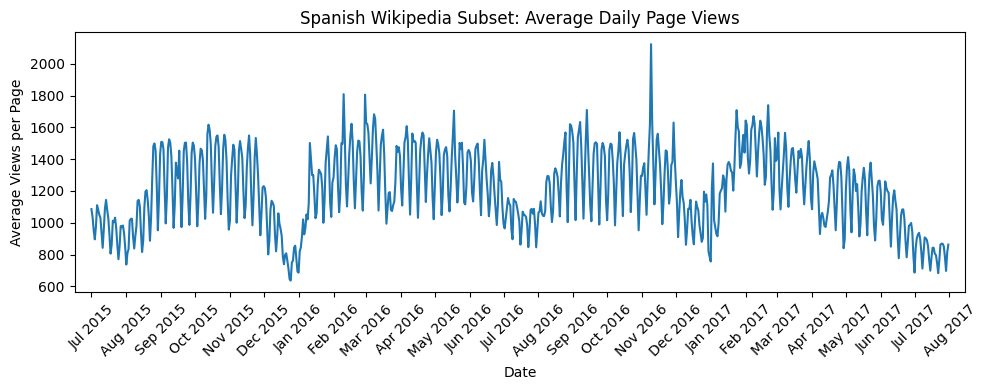

In [19]:
for lang in labels.keys():
    plot_and_save_lang(lang)

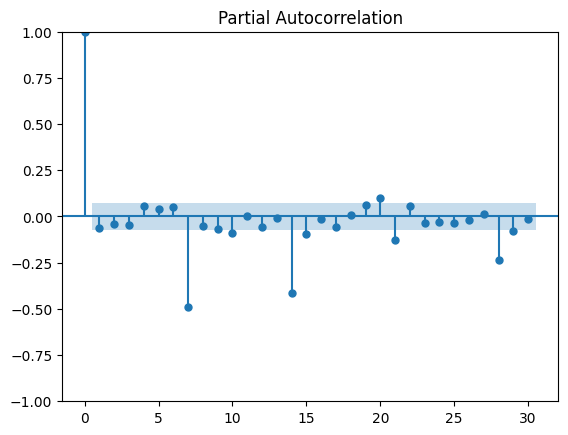

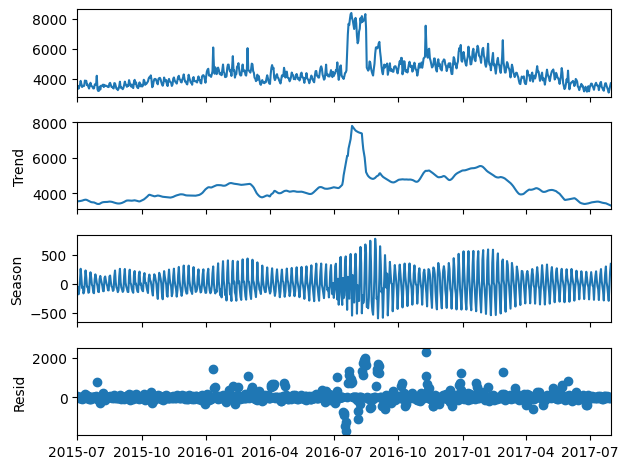

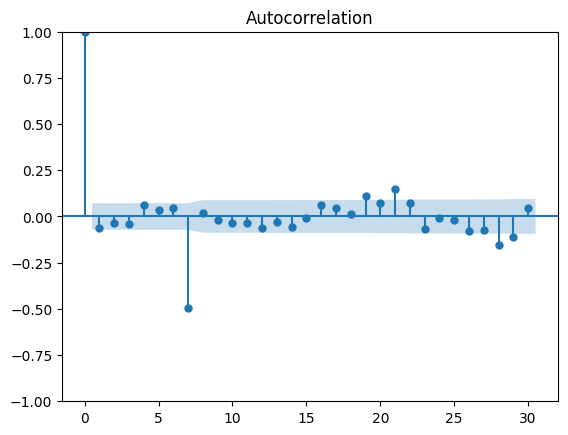

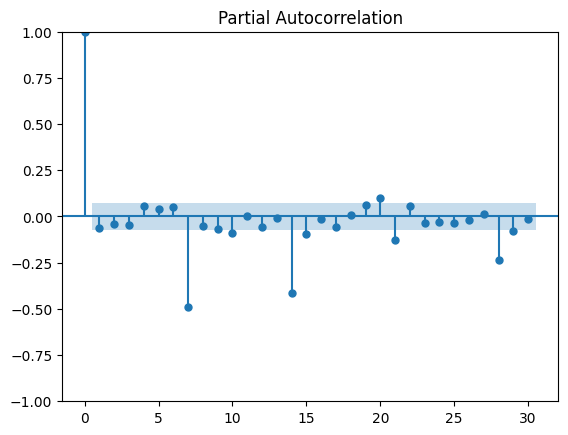

In [22]:
series = avg_views_by_lang["en"]
series_test = avg_views_by_lang_test["en"]

stl = STL(series, period=7, robust=True)
res = stl.fit()
res.plot()

series_diff1 = series.diff(periods=1)
series_diff1_7 = series_diff1.diff(periods=7)



plot_acf(series_diff1_7.dropna(), lags=30)
plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


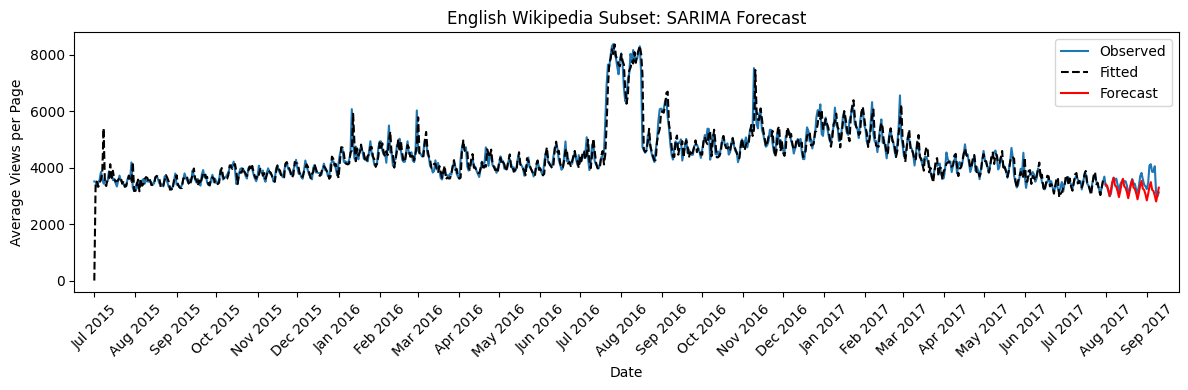

In [24]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(2,1,1,7))
fit = model.fit()

# Forecast next 30 days
forecast = fit.forecast(steps=41)
fitted_values = fit.fittedvalues

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('English Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()



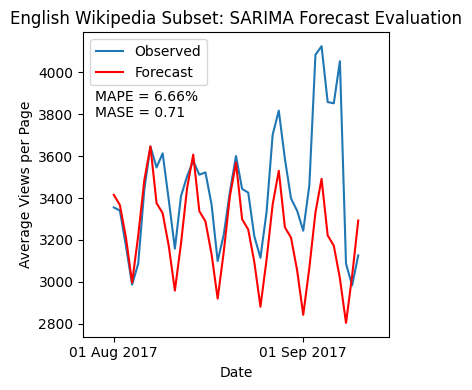

In [58]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))


plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend()
plt.title('English Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()


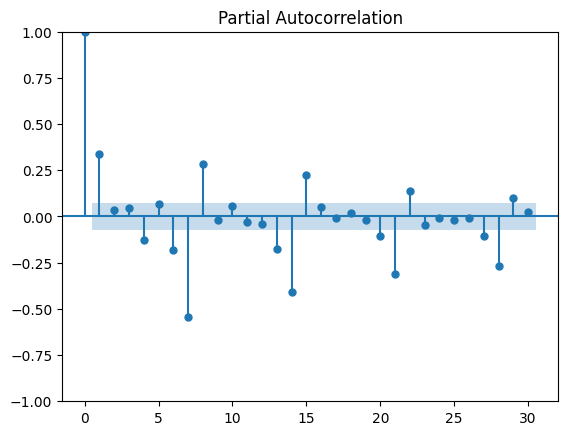

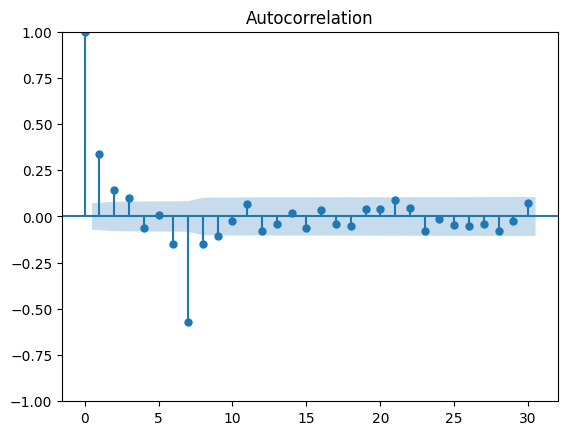

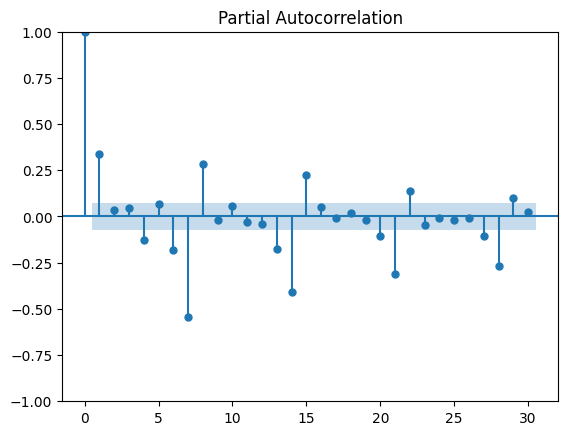

In [ ]:
series = avg_views_by_lang["ja"]
series_test = avg_views_by_lang_test["ja"]

# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

series_diff7_7 = series_diff7.diff(periods=7)


# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

plot_acf(series_diff7_7.dropna(), lags=30)
plot_pacf(series_diff7_7.dropna(), lags=30)



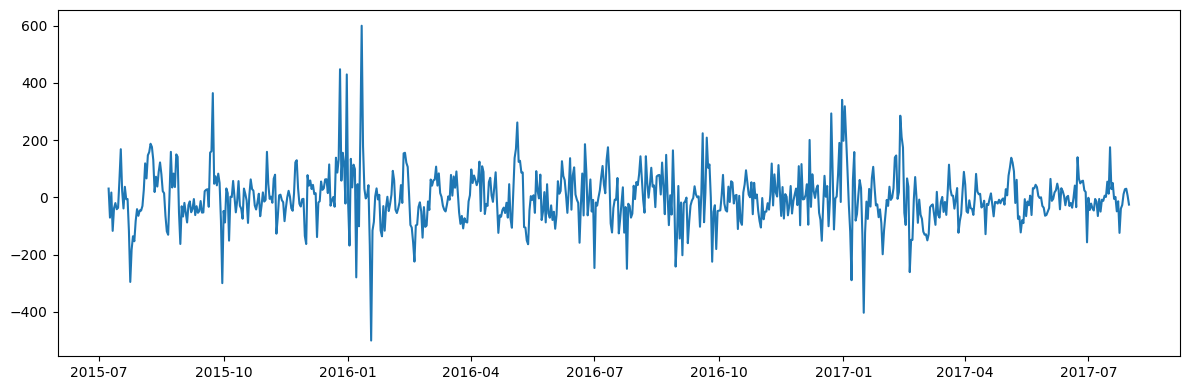

In [29]:
plt.figure(figsize=(12,4))
plt.plot(series_diff7.index, series_diff7)
plt.tight_layout()
plt.show()

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


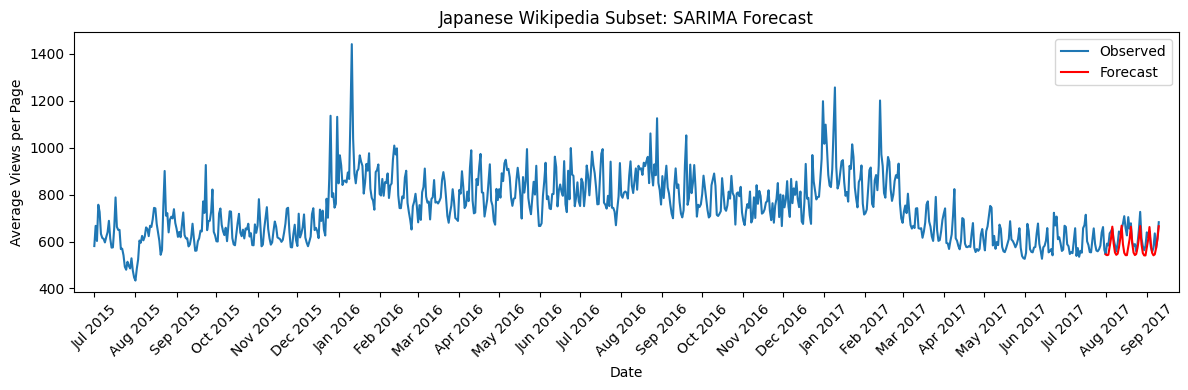

In [62]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(2,1,2,7))
fit = model.fit()

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Japanese Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()

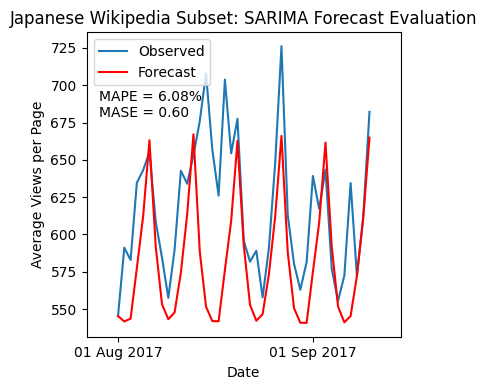

In [63]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Japanese Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

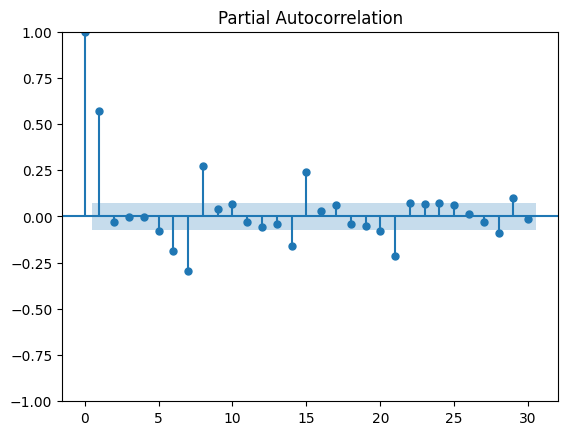

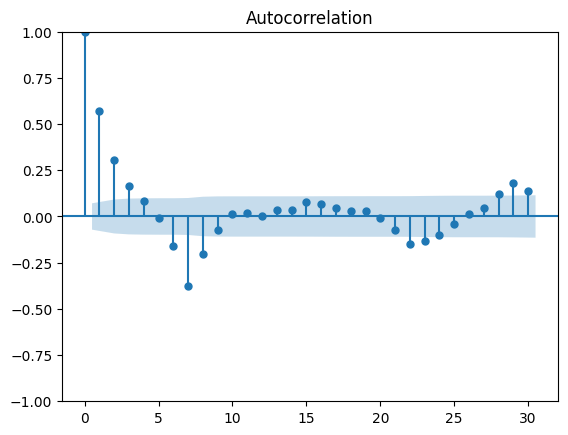

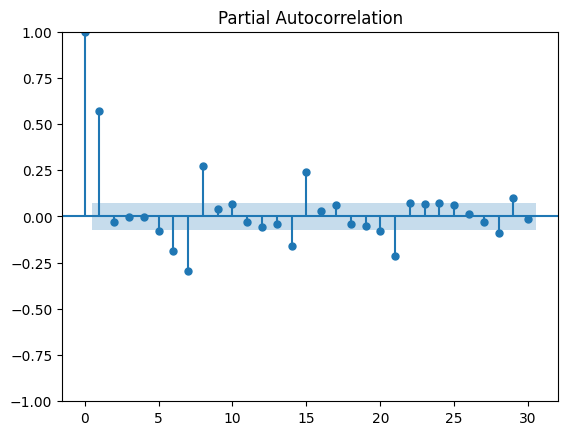

In [64]:
series = avg_views_by_lang["de"]
series_test = avg_views_by_lang_test["de"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff7.dropna(), lags=30)
plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


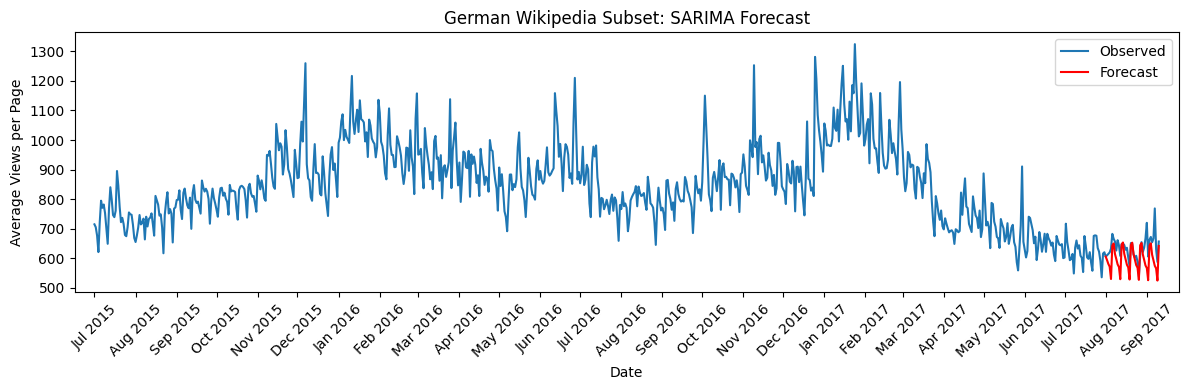

In [65]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,7))
fit = model.fit()
#fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
#plt.plot(series.index, fitted_values, label="Fitted (in-sample)", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('German Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


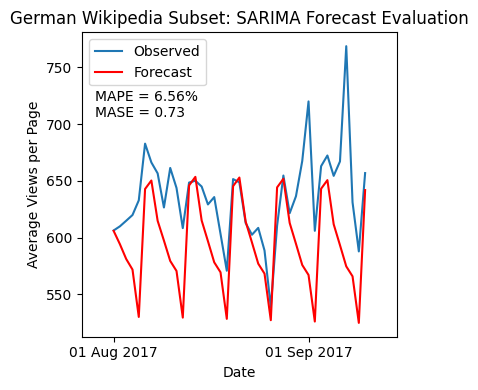

In [66]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('German Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

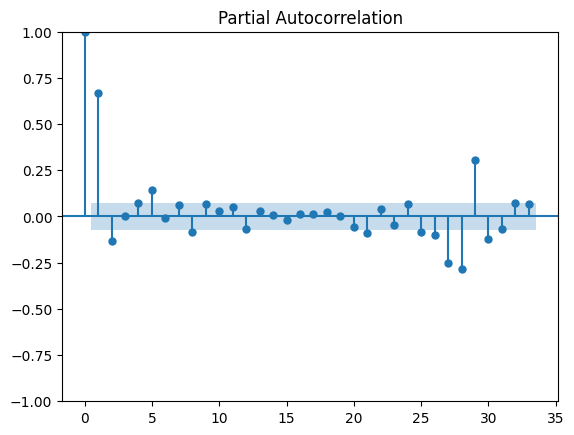

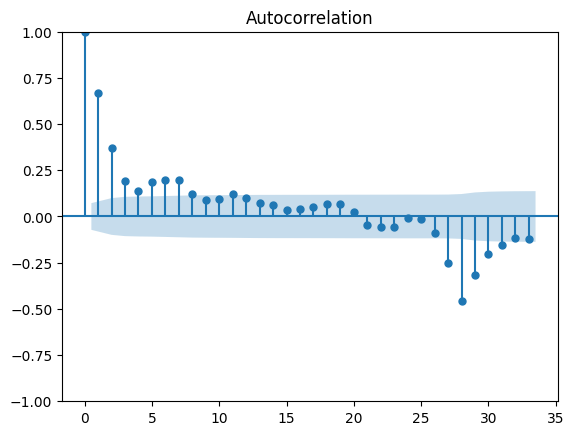

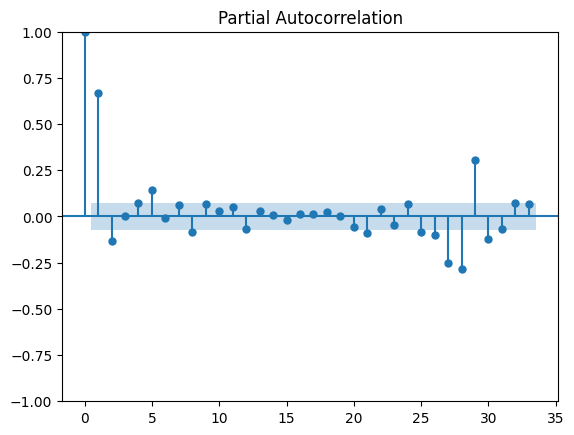

In [77]:
series = avg_views_by_lang["na"]
series_test = avg_views_by_lang_test["na"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff28 = series.diff(periods=28)

series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff28.dropna(), lags=33)
plot_pacf(series_diff28.dropna(), lags=33)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


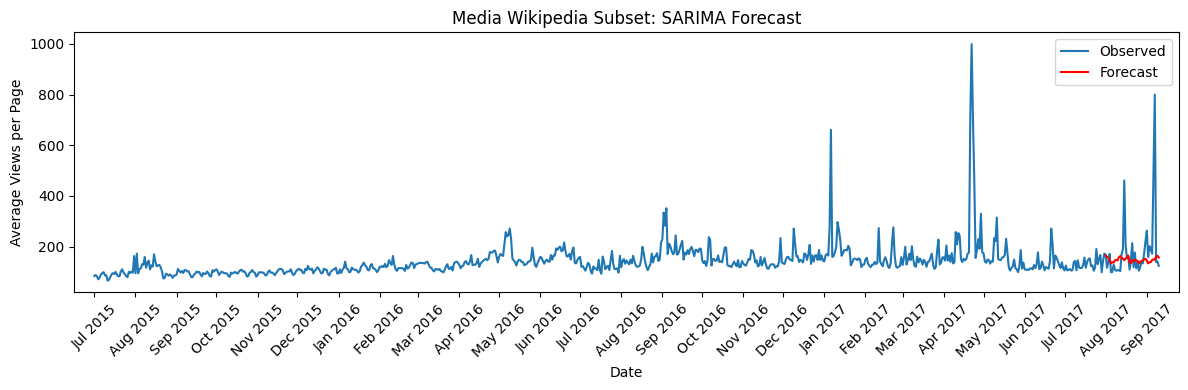

In [83]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,2), seasonal_order=(1,1,2,28))
# model = SARIMAX(series, order=(1,1,2), seasonal_order=(1,1,2,28))
fit = model.fit()
#fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
#plt.plot(series.index, fitted_values, label="Fitted (in-sample)", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Media Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


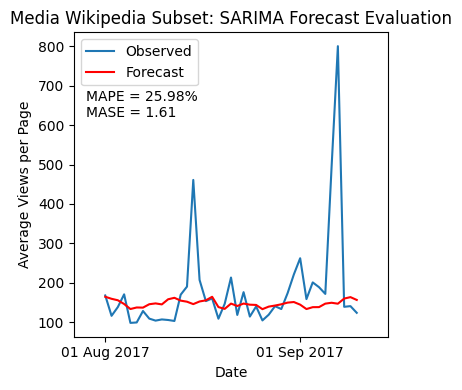

In [84]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[28:] - series.values[:-28]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Media Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

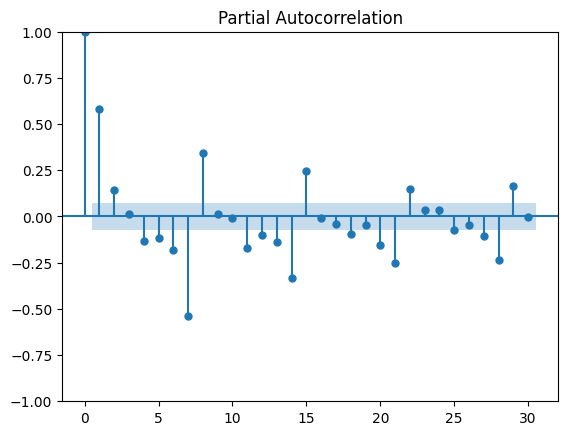

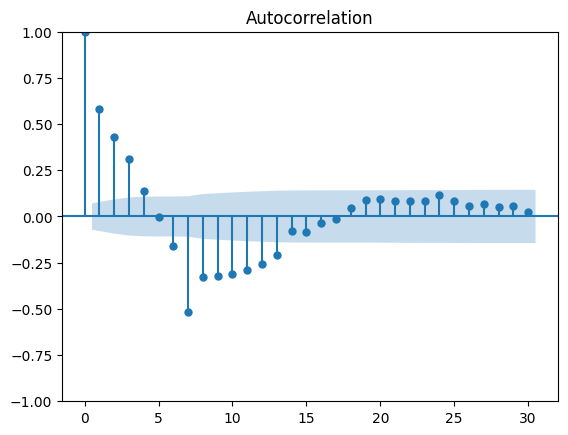

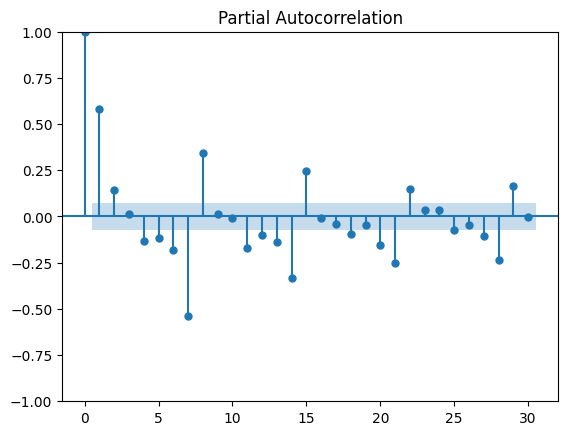

In [85]:
series = avg_views_by_lang["fr"]
series_test = avg_views_by_lang_test["fr"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

series_diff7_7 = series_diff7.diff(periods=7)


# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

plot_acf(series_diff7_7.dropna(), lags=30)
plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


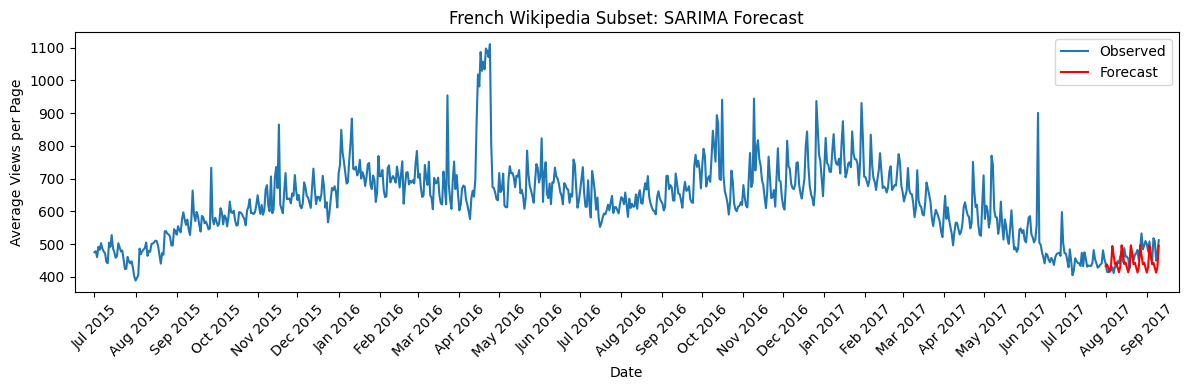

In [86]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,7))
fit = model.fit()
#fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
#plt.plot(series.index, fitted_values, label="Fitted (in-sample)", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('French Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


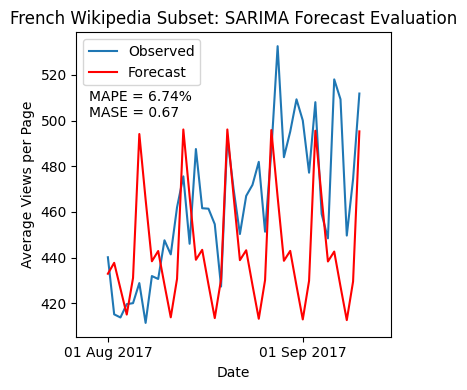

In [87]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('French Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

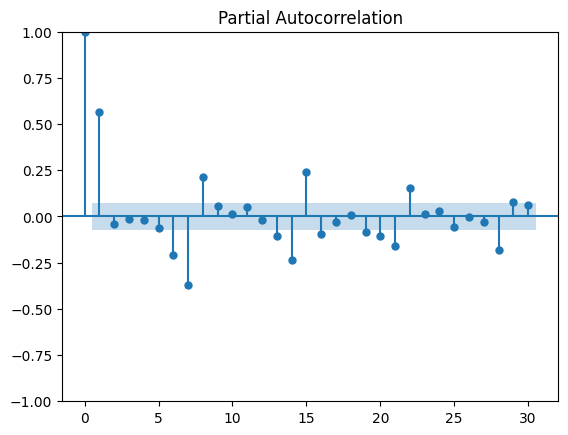

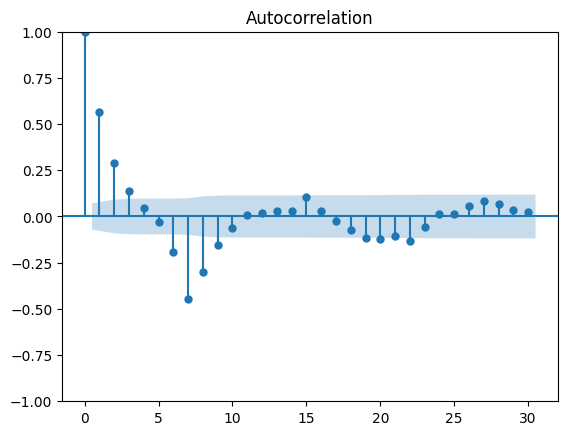

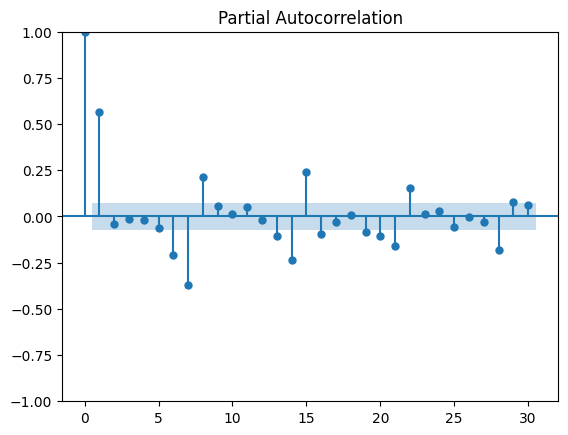

In [92]:
series = avg_views_by_lang["zh"]
series_test = avg_views_by_lang_test["zh"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

# series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff7.dropna(), lags=30)
plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


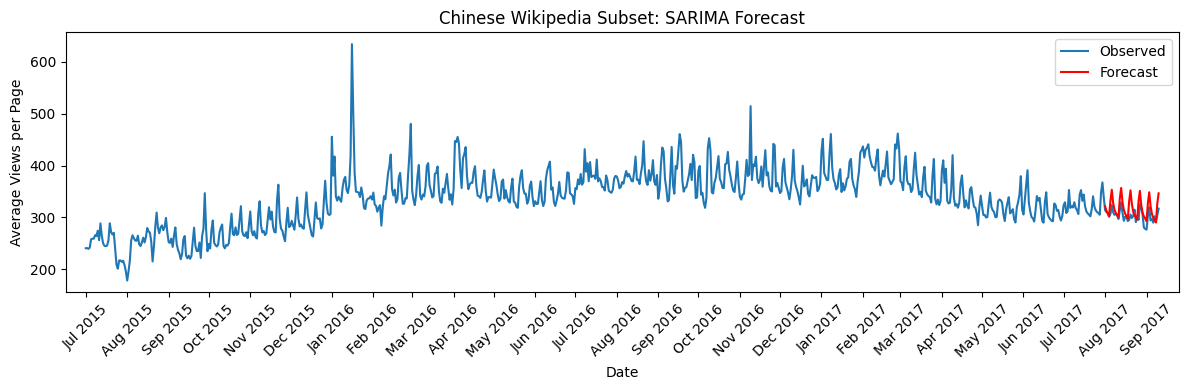

In [93]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,2,1,7))
fit = model.fit()
#fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
#plt.plot(series.index, fitted_values, label="Fitted (in-sample)", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Chinese Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


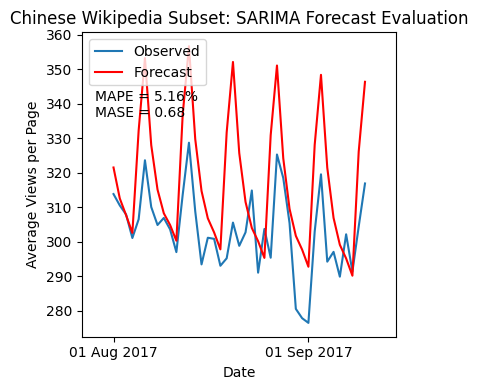

In [94]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Chinese Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

In [ ]:
#labels={'en':'English','ja':'Japanese','de':'German',
#        'na':'Media','fr':'French','zh':'Chinese',
#        'ru':'Russian','es':'Spanish'
#       }

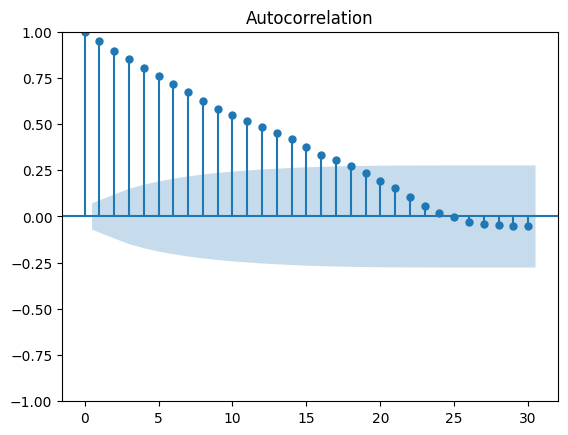

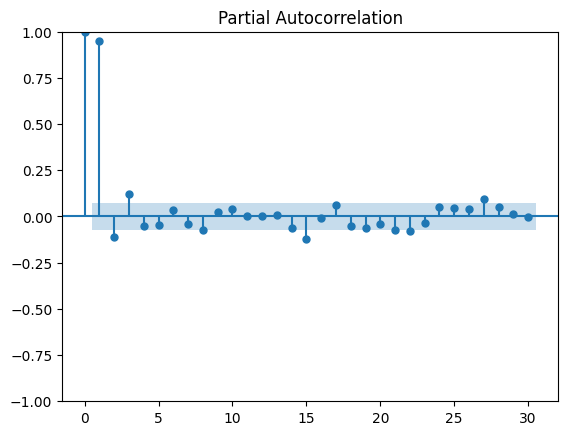

In [95]:
series = avg_views_by_lang["ru"]
series_test = avg_views_by_lang_test["ru"]
plot_acf(series.dropna(), lags=30)
plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

# series_diff7_7 = series_diff7.diff(periods=7)


# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


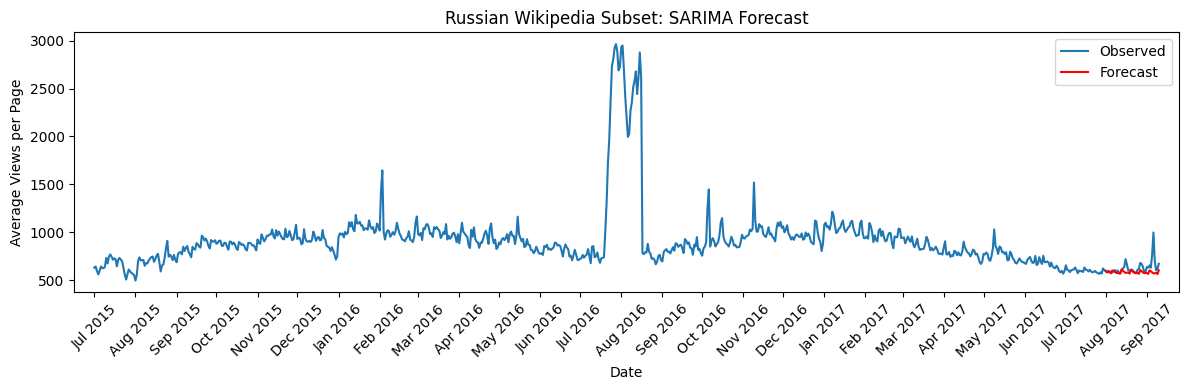

In [96]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,0), seasonal_order=(1,1,0,7))
fit = model.fit()
#fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
#plt.plot(series.index, fitted_values, label="Fitted (in-sample)", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Russian Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


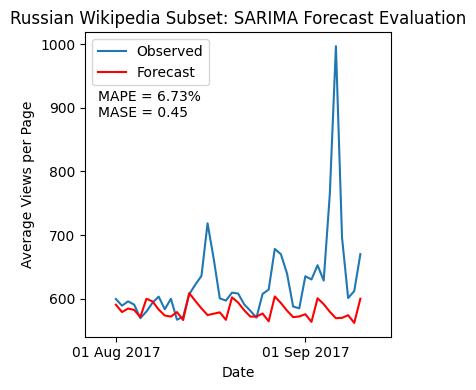

In [97]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Russian Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

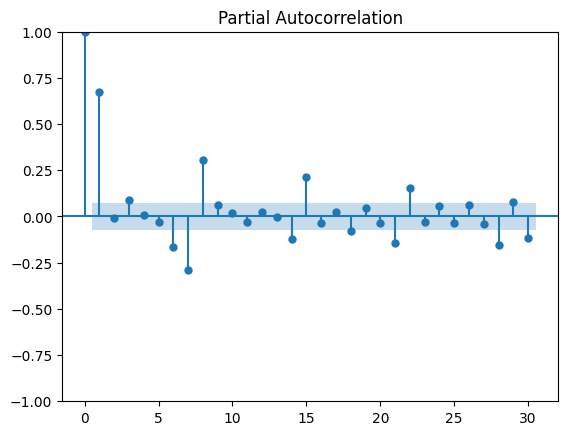

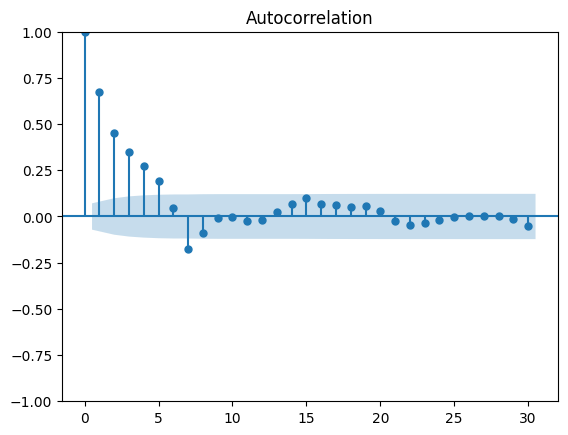

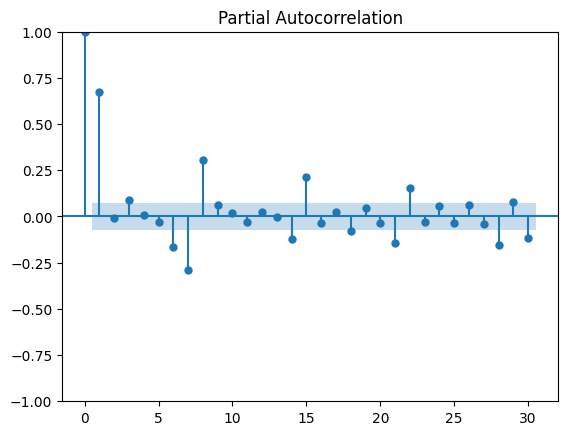

In [10]:
series = avg_views_by_lang["es"]
series_test = avg_views_by_lang_test["es"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

# series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff7.dropna(), lags=30)
plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn(

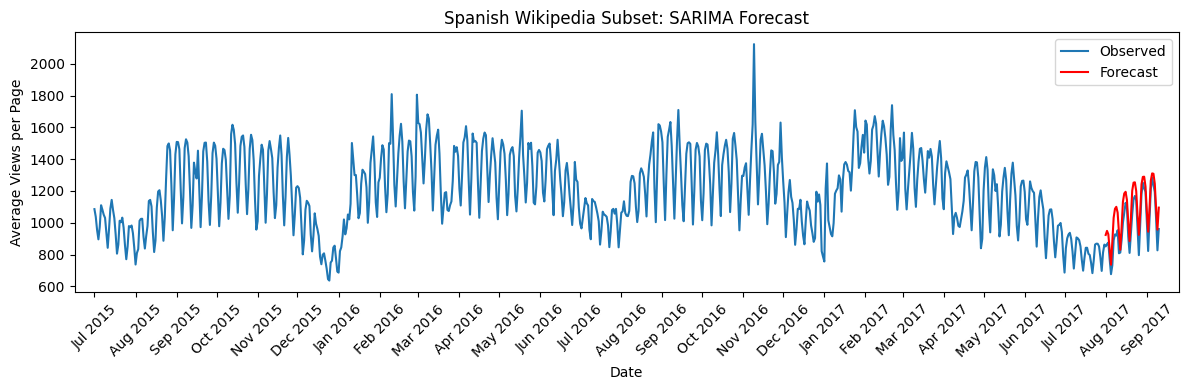

In [11]:
# Fit SARIMA model
model = SARIMAX(series, order=(2,0,1), seasonal_order=(2,1,1,7))
#model = SARIMAX(series, order=(2,0,1), seasonal_order=(2,1,1,7))
fit = model.fit()
#fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
#plt.plot(series.index, fitted_values, label="Fitted (in-sample)", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Spanish Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()

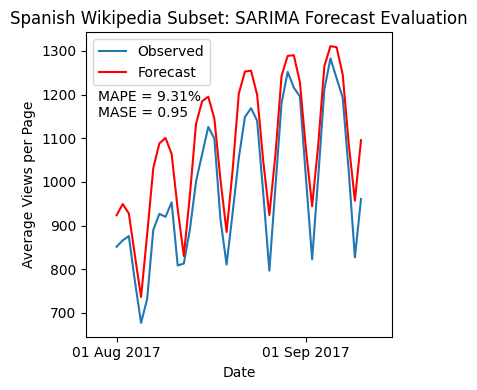

In [12]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Spanish Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

08:37:59 - cmdstanpy - INFO - Chain [1] start processing
08:37:59 - cmdstanpy - INFO - Chain [1] done processing


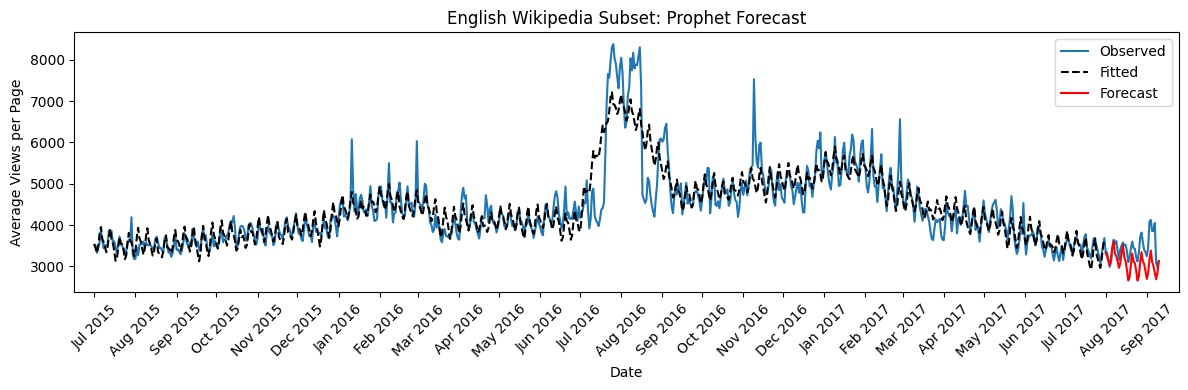

In [16]:
series = avg_views_by_lang["en"]
series_test = avg_views_by_lang_test["en"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('English Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

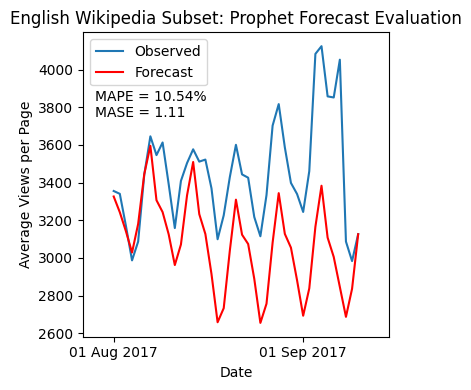

In [77]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('English Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

08:38:21 - cmdstanpy - INFO - Chain [1] start processing
08:38:21 - cmdstanpy - INFO - Chain [1] done processing


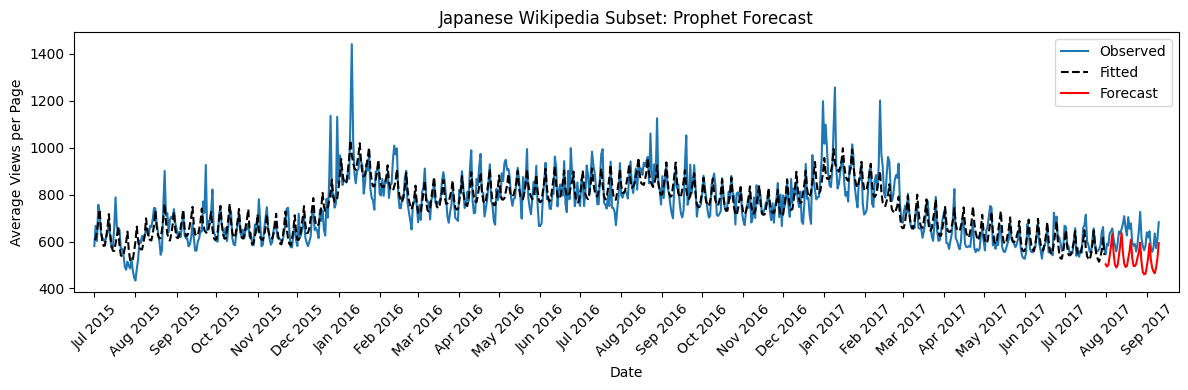

In [17]:
series = avg_views_by_lang["ja"]
series_test = avg_views_by_lang_test["ja"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Japanese Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

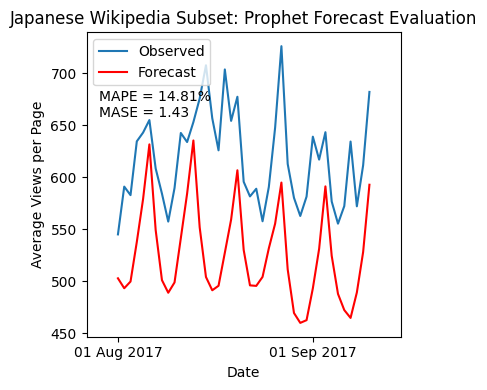

In [79]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Japanese Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

08:42:47 - cmdstanpy - INFO - Chain [1] start processing
08:42:47 - cmdstanpy - INFO - Chain [1] done processing


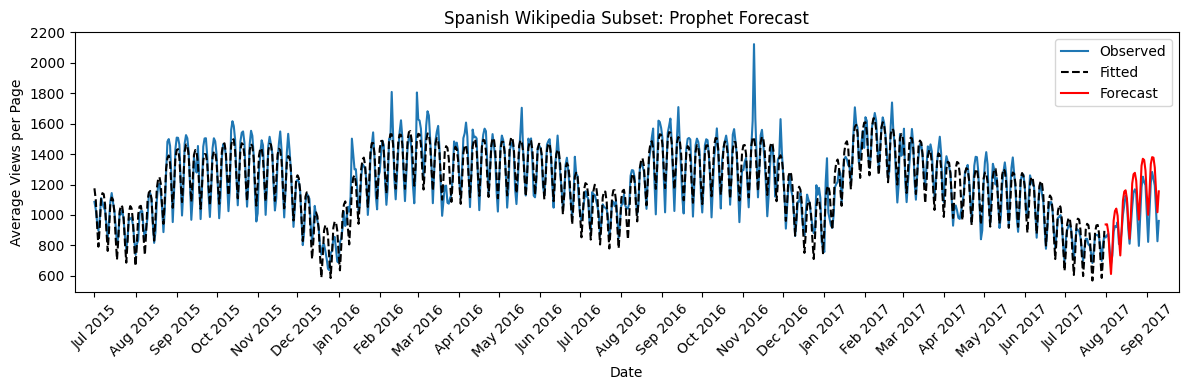

In [26]:
series = avg_views_by_lang["es"]
series_test = avg_views_by_lang_test["es"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Spanish Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

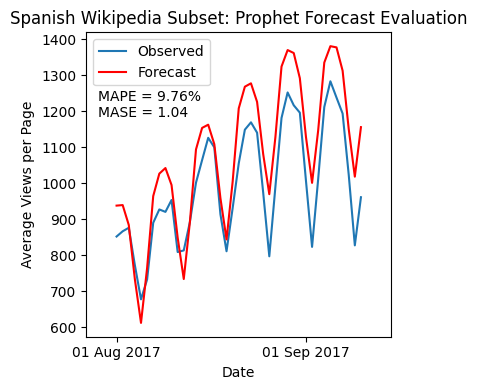

In [27]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Spanish Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

In [ ]:
# labels={'en':'English','ja':'Japanese','de':'German',
#         'na':'Media','fr':'French','zh':'Chinese',
#         'ru':'Russian','es':'Spanish'
#        }

08:41:08 - cmdstanpy - INFO - Chain [1] start processing
08:41:08 - cmdstanpy - INFO - Chain [1] done processing


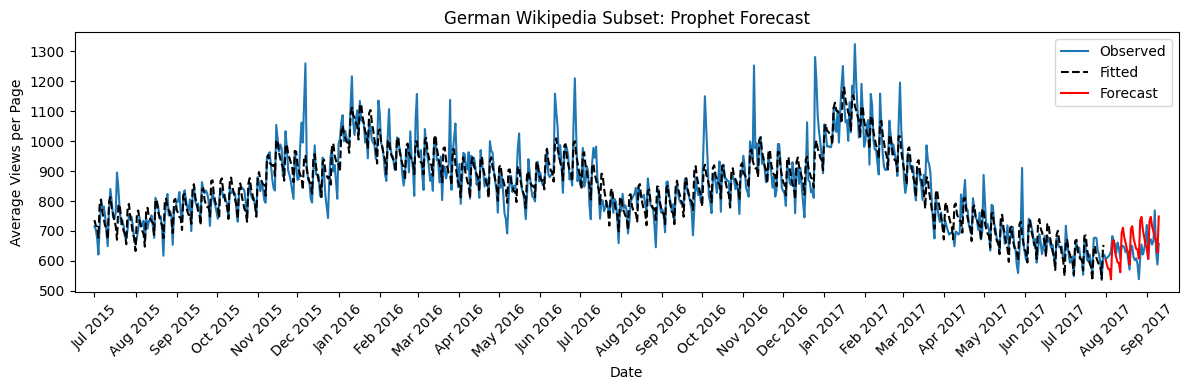

In [ ]:
series = avg_views_by_lang["de"]
series_test = avg_views_by_lang_test["de"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('German Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

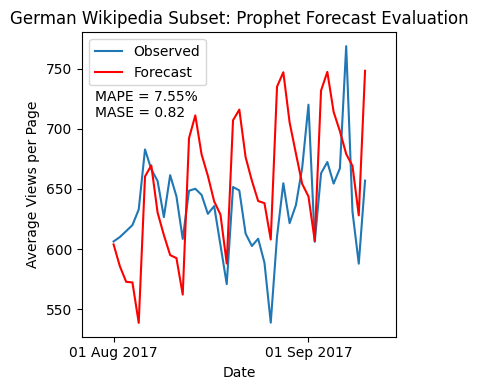

In [25]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('German Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:00:05 - cmdstanpy - INFO - Chain [1] start processing
09:00:05 - cmdstanpy - INFO - Chain [1] done processing


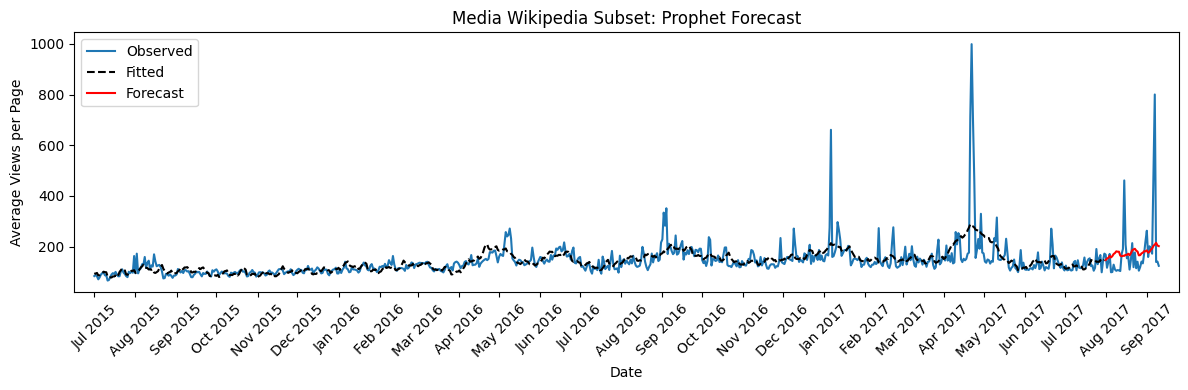

In [36]:
series = avg_views_by_lang["na"]
series_test = avg_views_by_lang_test["na"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Media Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

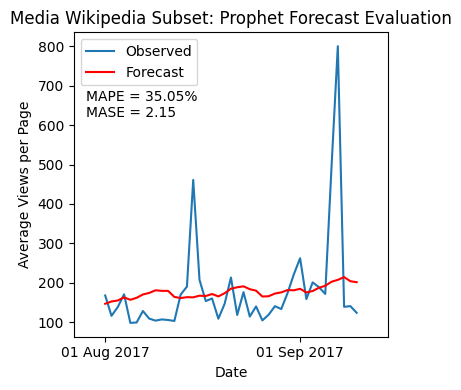

In [38]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Media Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:02:47 - cmdstanpy - INFO - Chain [1] start processing
09:02:47 - cmdstanpy - INFO - Chain [1] done processing


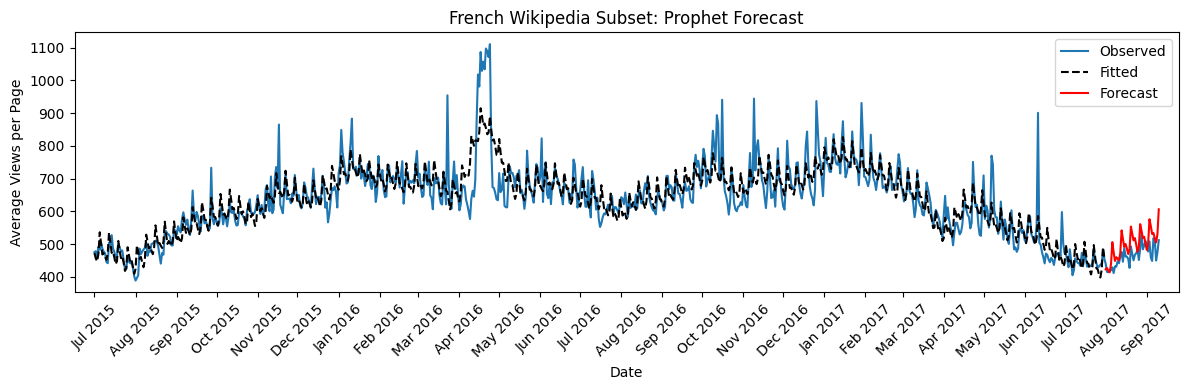

In [39]:
series = avg_views_by_lang["fr"]
series_test = avg_views_by_lang_test["fr"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('French Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

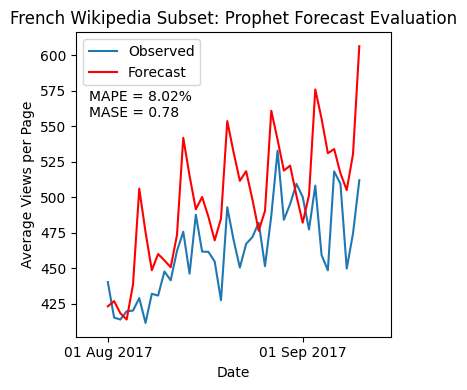

In [40]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('French Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:05:09 - cmdstanpy - INFO - Chain [1] start processing
09:05:09 - cmdstanpy - INFO - Chain [1] done processing


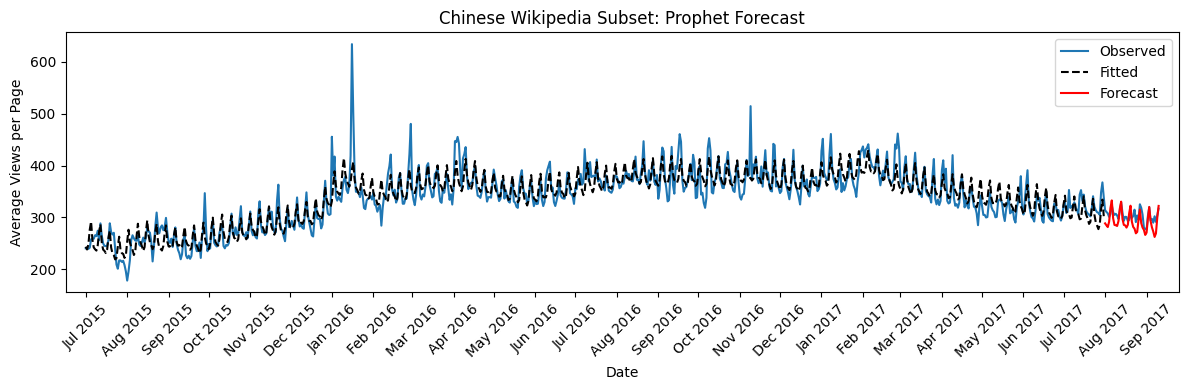

In [42]:
series = avg_views_by_lang["zh"]
series_test = avg_views_by_lang_test["zh"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Chinese Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

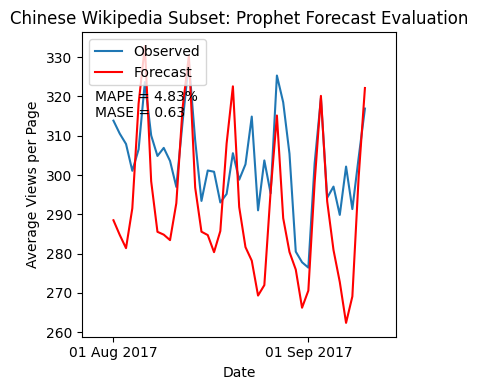

In [43]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Chinese Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:08:56 - cmdstanpy - INFO - Chain [1] start processing
09:08:56 - cmdstanpy - INFO - Chain [1] done processing


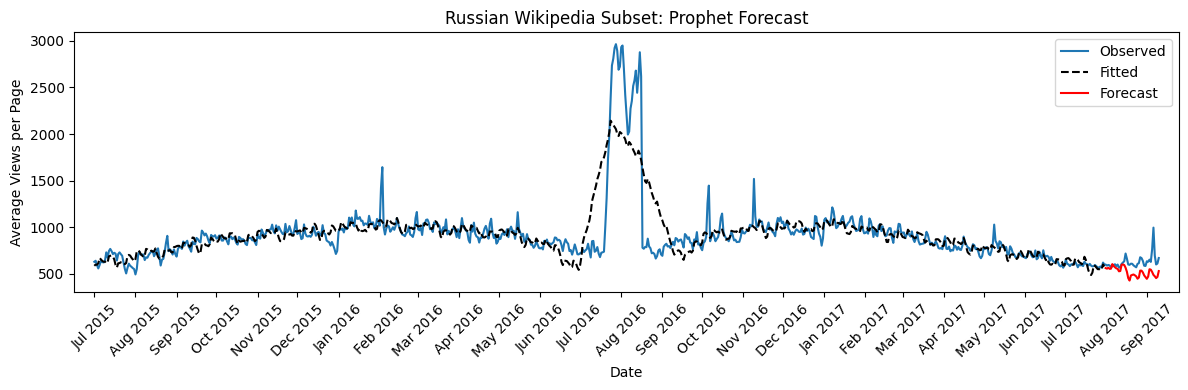

In [49]:
series = avg_views_by_lang["ru"]
series_test = avg_views_by_lang_test["ru"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Russian Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

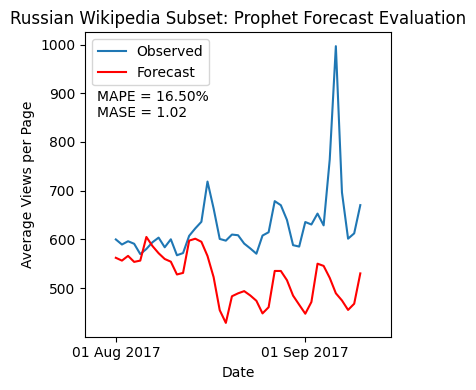

In [50]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Russian Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()